<a href="https://colab.research.google.com/github/shivkumarganesh/Advance-Deep-Learning/blob/main/Assignment%202/Perceiver_IO_Optical_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-requisite

In [11]:
!pip install dm-haiku
!pip install einops

!mkdir /content/perceiver
!touch /content/perceiver/__init__.py
!wget -O /content/perceiver/io_processors.py https://raw.githubusercontent.com/deepmind/deepmind-research/master/perceiver/io_processors.py
!wget -O /content/perceiver/perceiver.py https://raw.githubusercontent.com/deepmind/deepmind-research/master/perceiver/perceiver.py
!wget -O /content/perceiver/position_encoding.py https://raw.githubusercontent.com/deepmind/deepmind-research/master/perceiver/position_encoding.py

mkdir: cannot create directory ‘/content/perceiver’: File exists
--2021-10-10 06:18:08--  https://raw.githubusercontent.com/deepmind/deepmind-research/master/perceiver/io_processors.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29359 (29K) [text/plain]
Saving to: ‘/content/perceiver/io_processors.py’

/content/perceiver/ 100%[===================>]  28.67K  --.-KB/s    in 0s      

2021-10-10 06:18:08 (69.3 MB/s) - ‘/content/perceiver/io_processors.py’ saved [29359/29359]

--2021-10-10 06:18:08--  https://raw.githubusercontent.com/deepmind/deepmind-research/master/perceiver/perceiver.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.git

#Importing useful frunctions

In [12]:
#IMPORTS
import functools
import itertools
import pickle

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import cv2
import imageio

from perceiver import perceiver, io_processors

# Perceiver Optical Flow Model Creation

In [13]:
# MODEL CREATION
FLOW_SCALE_FACTOR = 20
# The network assumes images are of the following size
TRAIN_SIZE = (368, 496)

def optical_flow(images):
  """Perceiver IO model for optical flow.

  Args:
    images: Array of two stacked images, of shape [B, 2, H, W, C]
  Returns:
    Optical flow field, of shape [B, H, W, 2].
  """
  input_preprocessor = io_processors.ImagePreprocessor(
      position_encoding_type='fourier',
      fourier_position_encoding_kwargs=dict(
          num_bands=64,
          max_resolution=TRAIN_SIZE,
          sine_only=False,
          concat_pos=True,
      ),
      n_extra_pos_mlp=0,
      prep_type='patches',
      spatial_downsample=1,
      conv_after_patching=True,
      temporal_downsample=2)

  encoder = encoder = perceiver.PerceiverEncoder(
      num_self_attends_per_block=24,
      # Weights won't be shared if num_blocks is set to 1.
      num_blocks=1,
      z_index_dim=2048,
      num_cross_attend_heads=1,
      num_z_channels=512,
      num_self_attend_heads=16,
      cross_attend_widening_factor=1,
      self_attend_widening_factor=1,
      dropout_prob=0.0,
      z_pos_enc_init_scale=0.02,
      cross_attention_shape_for_attn='kv',
      name='perceiver_encoder')

  decoder = perceiver.FlowDecoder(
      TRAIN_SIZE,
      rescale_factor=100.0,
      use_query_residual=False,
      output_num_channels=2,
      output_w_init=jnp.zeros,
      # We query the decoder using the first frame features
      # rather than a standard decoder position encoding.
      position_encoding_type='fourier',
      fourier_position_encoding_kwargs=dict(
          concat_pos=True,
          max_resolution=TRAIN_SIZE,
          num_bands=64,
          sine_only=False
      )
  )

  model = perceiver.Perceiver(
      input_preprocessor=input_preprocessor,
      encoder=encoder,
      decoder=decoder,
      output_postprocessor=None)

  return model(io_processors.patches_for_flow(images),
               is_training=False) * FLOW_SCALE_FACTOR


optical_flow = hk.transform(optical_flow)

In [14]:
#Function to compute flow between pairs of images
_apply_optical_flow_model = jax.jit(optical_flow.apply)

def compute_grid_indices(image_shape, patch_size=TRAIN_SIZE, min_overlap=20):
  if min_overlap >= TRAIN_SIZE[0] or min_overlap >= TRAIN_SIZE[1]:
    raise ValueError(
        f"Overlap should be less than size of patch (got {min_overlap}"
        f"for patch size {patch_size}).")
  ys = list(range(0, image_shape[0], TRAIN_SIZE[0] - min_overlap))
  xs = list(range(0, image_shape[1], TRAIN_SIZE[1] - min_overlap))
  # Make sure the final patch is flush with the image boundary
  ys[-1] = image_shape[0] - patch_size[0]
  xs[-1] = image_shape[1] - patch_size[1]
  return itertools.product(ys, xs)

def compute_optical_flow(params, rng, img1, img2, grid_indices,
                       patch_size=TRAIN_SIZE):
  """Function to compute optical flow between two images.

  To compute the flow between images of arbitrary sizes, we divide the image
  into patches, compute the flow for each patch, and stitch the flows together.

  Args:
    params: model parameters
    rng: jax.random.PRNGKey, not used in this model
    img1: first image
    img2: second image
    grid_indices: indices of the upper left corner for each patch.
    patch_size: size of patch, should be TRAIN_SIZE.
  """
  imgs = jnp.stack([img1, img2], axis=0)[None]
  height = imgs.shape[-3]
  width = imgs.shape[-2]

  if height < patch_size[0]:
    raise ValueError(
        f"Height of image (shape: {imgs.shape}) must be at least {patch_size[0]}."
        "Please pad or resize your image to the minimum dimension."
    )
  if width < patch_size[1]:
    raise ValueError(
        f"Width of image (shape: {imgs.shape}) must be at least {patch_size[1]}."
        "Please pad or resize your image to the minimum dimension."
    )

  flows = 0
  flow_count = 0

  for y, x in grid_indices:
    inp_piece = imgs[..., y : y + patch_size[0],
                     x : x + patch_size[1], :]
    flow_piece = _apply_optical_flow_model(params, rng, inp_piece)
    weights_x, weights_y = jnp.meshgrid(
        jnp.arange(patch_size[1]), jnp.arange(patch_size[0]))

    weights_x = jnp.minimum(weights_x + 1, patch_size[1] - weights_x)
    weights_y = jnp.minimum(weights_y + 1, patch_size[0] - weights_y)
    weights = jnp.minimum(weights_x, weights_y)[jnp.newaxis, :, :,
                                                jnp.newaxis]
    padding = [(0, 0), (y, height - y - patch_size[0]),
               (x, width - x - patch_size[1]), (0, 0)]
    flows += jnp.pad(flow_piece * weights, padding)
    flow_count += jnp.pad(weights, padding)

  flows /= flow_count
  return flows

In [15]:
#Load parameters from checkpoint

!wget -O optical_flow_checkpoint.pystate https://storage.googleapis.com/perceiver_io/optical_flow_checkpoint.pystate

rng = jax.random.PRNGKey(42)
with open("optical_flow_checkpoint.pystate", "rb") as f:
  params = pickle.loads(f.read())

state = {}

--2021-10-10 06:18:09--  https://storage.googleapis.com/perceiver_io/optical_flow_checkpoint.pystate
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164271840 (157M) [application/octet-stream]
Saving to: ‘optical_flow_checkpoint.pystate’

optical_flow_checkp 100%[===================>] 156.66M   134MB/s    in 1.2s    

2021-10-10 06:18:10 (134 MB/s) - ‘optical_flow_checkpoint.pystate’ saved [164271840/164271840]



In [16]:
# Download two example frames from the Sintel dataset.

!wget -O sintel_frame1.png https://storage.googleapis.com/perceiver_io/sintel_frame1.png
!wget -O sintel_frame2.png https://storage.googleapis.com/perceiver_io/sintel_frame2.png

with open("sintel_frame1.png", "rb") as f:
  im1 = imageio.imread(f)
with open("sintel_frame2.png", "rb") as f:
  im2 = imageio.imread(f)

--2021-10-10 06:18:11--  https://storage.googleapis.com/perceiver_io/sintel_frame1.png
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 74.125.133.128, 74.125.140.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 710411 (694K) [application/octet-stream]
Saving to: ‘sintel_frame1.png’

sintel_frame1.png   100%[===================>] 693.76K  --.-KB/s    in 0.007s  

2021-10-10 06:18:11 (96.5 MB/s) - ‘sintel_frame1.png’ saved [710411/710411]

--2021-10-10 06:18:11--  https://storage.googleapis.com/perceiver_io/sintel_frame2.png
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 66.102.1.128, 142.251.5.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 712519 (696K) [application/octet-stream]
Saving to: ‘sintel_frame2.png’


In [17]:
im1

Array([[[10, 17, 19],
        [12, 21, 22],
        [14, 24, 26],
        ...,
        [22, 30, 31],
        [15, 24, 26],
        [27, 44, 47]],

       [[10, 18, 19],
        [12, 21, 22],
        [14, 24, 26],
        ...,
        [21, 32, 34],
        [17, 26, 28],
        [15, 25, 26]],

       [[11, 19, 20],
        [13, 23, 25],
        [15, 25, 27],
        ...,
        [24, 36, 38],
        [21, 34, 36],
        [24, 38, 40]],

       ...,

       [[12, 22, 25],
        [14, 24, 27],
        [23, 38, 44],
        ...,
        [29, 60, 68],
        [29, 60, 68],
        [31, 63, 71]],

       [[11, 20, 23],
        [13, 22, 25],
        [22, 36, 41],
        ...,
        [28, 59, 67],
        [26, 54, 62],
        [25, 52, 58]],

       [[11, 19, 22],
        [12, 20, 24],
        [16, 27, 31],
        ...,
        [29, 59, 68],
        [28, 58, 66],
        [24, 51, 58]]], dtype=uint8)

# Image Utilities

In [18]:
#Image Utility Functions

def normalize(im):
  return im / 255.0 * 2 - 1

def visualize_flow(flow):
  flow = np.array(flow)
  # Use Hue, Saturation, Value colour model 
  hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
  hsv[..., 2] = 255

  mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
  hsv[..., 0] = ang / np.pi / 2 * 180
  hsv[..., 1] = np.clip(mag * 255 / 24, 0, 255)
  bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
  plt.imshow(bgr)

# Running Model

In [19]:
# Compute optical flow

grid_indices = compute_grid_indices(im1.shape)
flow = compute_optical_flow(params, rng, normalize(im1), normalize(im2), grid_indices)

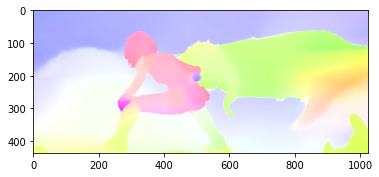

In [20]:
# Visualize the computed flow
visualize_flow(flow[0])